# MSRE U235 Power Run
In the 1966 the MSRE started power operations with U235 as main fissile material. 
In this notebook we will run a fully coupled transport-depletion simulation using a CAD design version developed by [Copenhagen Atomics](https://www.copenhaagenatomics.com) using the CAE tool OnShape and made available for export here: [onshape msre model]((https://cad.onshape.com/documents/4f04f63bfd4138a61a54b3f8/v/b8c29a0cedda86dfc6948111/)).

To effectively run OpenMC, the MSRE CAD geometry is meshed and converted into an h5m format readable by OpenMC, using the open-source meshing tool [CAD-to-OpenMC](https://github.com/openmsr/CAD_to_OpenMC). 

Furthermore, to model fission products removal we will use OpenMC [Transfer rates theory](https://docs.openmc.org/en/latest/methods/depletion.html#transfer-rates) capability available through the depletion solver and integrated into the main code from version 0.14.0. 


In [9]:
%matplotlib inline

import openmc
import openmc.deplete
import numpy as np
from math import log10
import matplotlib.pyplot as plt
import os 

os.system('rm *.xml *.h5')

0

For materials nuclear properties we will be using the same definitions used in the first criticality test derived from the [MSRE benchmark evaluation project](https://www.osti.gov/servlets/purl/1617123) and available in the International Reactor Physics Experiment Evaulation Project (IRPhEP) handbook. 

In [10]:
# Define materials 
salt_temp = 638.3 # in C
salt_density = 2.32556 # g/cm3
salt = openmc.Material(name="salt", temperature = salt_temp + 273.15)
salt.add_nuclide('Li6', 0.0000131541127279649)
salt.add_nuclide('Li7', 0.263082254559299)
salt.add_nuclide('Be9', 0.118688703357854)
salt.add_nuclide('Zr90', 0.0105474637491834)
salt.add_nuclide('Zr91', 0.00230014661352455)
salt.add_nuclide('Zr92', 0.00351582124972781)
salt.add_nuclide('Zr94', 0.00356297220526352)
salt.add_nuclide('Zr96', 0.000574011632608622)
salt.add_nuclide('Hf174', 0.000000000838247756705461)
salt.add_nuclide('Hf176', 0.000000027557395001692)
salt.add_nuclide('Hf177', 0.0000000974463017170099)
salt.add_nuclide('Hf178', 0.000000142921242518281)
salt.add_nuclide('Hf179', 0.0000000713558402895524)
salt.add_nuclide('Hf180', 0.000000183785820657672)
salt.add_nuclide('U234', 0.000010347565467384)
salt.add_nuclide('U235', 0.00101016470221956)
salt.add_nuclide('U236', 0.00000422977321829143)
salt.add_nuclide('U238', 0.00216927473057667)
salt.add_nuclide('Fe54', 0.00000285638012142825)
salt.add_nuclide('Fe56', 0.0000448390593090724)
salt.add_nuclide('Fe57', 0.00000103552942297801)
salt.add_nuclide('Fe58', 0.000000137809956243416)
salt.add_nuclide('Cr50', 0.00000212334843928242)
salt.add_nuclide('Cr52', 0.000040946661076878)
salt.add_nuclide('Cr53', 0.00000464302267471169)
salt.add_nuclide('Cr54', 0.00000115574661884993)
salt.add_nuclide('Ni58', 0.00000586242358522768)
salt.add_nuclide('Ni60', 0.00000225819506936691)
salt.add_nuclide('Ni61', 0.0000000981621760803009)
salt.add_nuclide('Ni62', 0.00000031298397136929)
salt.add_nuclide('Ni64', 0.0000000797077903148755)
salt.add_nuclide('O16', 0.0000514608160260434)
salt.add_nuclide('O17', 0.0000000189357310970321)
salt.add_nuclide('O18', 0.0000000964845153990466)
salt.add_nuclide('F19', 0.594363006576997)
salt.set_density('g/cm3',salt_density)

#moderator blocks170
graphite = openmc.Material(name='graphite',temperature= salt_temp + 273.15)
graphite.set_density('g/cm3',1.8492)
graphite.add_element('C',0.999992212250888) #endfb71 does not have C12 cross sections
graphite.add_nuclide('B10', 1.76873036539477E-07)
graphite.add_nuclide('B11', 7.1193229306592E-07)
graphite.add_nuclide('V51', 2.12200224802724E-06)
graphite.add_nuclide('S32', 1.77900760271203E-06)
graphite.add_nuclide('S33', 1.40462754188233E-08)
graphite.add_nuclide('S34', 7.95955607066653E-08)
graphite.add_nuclide('S36', 1.87283672250977E-10)
graphite.add_nuclide('O16', 1.85674385782835E-06)
graphite.add_nuclide('O17', 6.81675170610618E-10)
graphite.add_nuclide('Si28', 5.31911333979174E-07)
graphite.add_nuclide('Si29', 2.70215087309286E-08)
graphite.add_nuclide('Si30', 1.78336189959512E-08)
graphite.add_nuclide('Al27', 4.0117589478321E-07)
graphite.add_nuclide('Fe54', 2.31047953307142E-09)
graphite.add_nuclide('Fe56', 3.62695875239409E-08)
graphite.add_nuclide('Fe57', 8.37622947917593E-10)
graphite.add_nuclide('Fe58', 1.11472237523719E-10)
graphite.add_nuclide('Ti46', 1.12809907219147E-09)
graphite.add_nuclide('Ti47', 1.01734025419449E-09)
graphite.add_nuclide('Ti48', 1.008041983054E-08)
graphite.add_nuclide('Ti49', 7.39759512794646E-10)
graphite.add_nuclide('Ti50', 7.08309478054763E-10)
graphite.add_nuclide('Mg24', 8.53578076978748E-09)
graphite.add_nuclide('Mg25', 1.0806153652092E-09)
graphite.add_nuclide('Mg26', 1.18975751709533E-09)
graphite.add_nuclide('Ca40', 4.58305905846326E-09)
graphite.add_nuclide('Ca42', 3.05880815220158E-11)
graphite.add_nuclide('Ca43', 6.38236631448551E-12)
graphite.add_nuclide('Ca44', 9.86193787556798E-11)
graphite.add_nuclide('Ca48', 8.8407592652503E-12)
graphite.add_s_alpha_beta('c_Graphite')

#inor-8
inor = openmc.Material(name='inor-8',temperature= salt_temp + 273.15)
inor.set_density('g/cm3',8.7745)
inor.add_element('Ni',(66+71)/2,'wo')
inor.add_element('Mo',(15+18)/2,'wo')
inor.add_element('Cr',(6+8)/2,'wo')
inor.add_element('Fe',5,'wo')
inor.add_element('C',(0.04+0.08)/2,'wo')
inor.add_element('Al',0.25,'wo')
inor.add_element('Ti',0.25,'wo')
inor.add_element('S',0.02,'wo')
inor.add_element('Mn',1.0,'wo')
inor.add_element('Si',1.0,'wo')
inor.add_element('Cu',0.35,'wo')
inor.add_element('B',0.010,'wo')
inor.add_element('W',0.5,'wo')
inor.add_element('P',0.015,'wo')
inor.add_element('Co',0.2,'wo')

#helium
helium = openmc.Material(name='helium')
helium.add_element('He',1.0)
helium.set_density('g/cm3',1.03*(10**-4))

#Control rods inconel clad
trace = 0.01
inconel = openmc.Material(name='inconel-600', temperature = 65.6 + 273.15)
inconel.add_element('Ni',78.5,percent_type='wo')
inconel.add_element('Cr',14.0,percent_type='wo')
inconel.add_element('Fe',6.5,percent_type='wo')
inconel.add_element('Mn',0.25,percent_type='wo')
inconel.add_element('Si',0.25,percent_type='wo')
inconel.add_element('Cu',0.2,percent_type='wo')
inconel.add_element('Co',0.2,percent_type='wo')
inconel.add_element('Al',0.2,percent_type='wo')
inconel.add_element('Ti',0.2,percent_type='wo')
inconel.add_element('Ta',0.5,percent_type='wo')
inconel.add_element('W',0.5,percent_type='wo')
inconel.add_element('Zn',0.2,percent_type='wo')
inconel.add_element('Zr',0.1,percent_type='wo')
inconel.add_element('C',trace,percent_type='wo')
inconel.add_element('Mo',trace,percent_type='wo')
inconel.add_element('Ag',trace,percent_type='wo')
inconel.add_element('B',trace,percent_type='wo')
inconel.add_element('Ba',trace,percent_type='wo')
inconel.add_element('Be',trace,percent_type='wo')
inconel.add_element('Ca',trace,percent_type='wo')
inconel.add_element('Cd',trace,percent_type='wo')
inconel.add_element('V',trace,percent_type='wo')
inconel.add_element('Sn',trace,percent_type='wo')
inconel.add_element('Mg',trace,percent_type='wo')
inconel.set_density('g/cm3',8.5)

#Control rods bushing posion material
Gd2O3 = openmc.Material()
Gd2O3.add_element('Gd',2)
Gd2O3.add_element('O',3)
Gd2O3.set_density('g/cm3',7.41)
Al2O3 = openmc.Material()
Al2O3.add_element('Al',2)
Al2O3.add_element('O',3)
Al2O3.set_density('g/cm3',3.95)
bush = openmc.Material.mix_materials([Gd2O3,Al2O3],[0.7,0.3],'wo')
bush.name='gd2o3-al2o3'
bush.temperature = 65.6 +273.15

#Concrete block
concrete = openmc.Material(name='concrete')
concrete.add_element('H',0.005,'wo')
concrete.add_element('O',0.496,'wo')
concrete.add_element('Si',0.314,'wo')
concrete.add_element('Ca',0.083,'wo')
concrete.add_element('Na',0.017,'wo')
concrete.add_element('Mn',0.002,'wo')
concrete.add_element('Al',0.046,'wo')
concrete.add_element('S',0.001,'wo')
concrete.add_element('K',0.019,'wo')
concrete.add_element('Fe',0.012,'wo')
concrete.set_density('g/cm3',2.35)

#Thermal shielding as water and SS305 (50-50)
water = openmc.Material()
water.add_element('H',2)
water.add_element('O',1)
water.set_density('g/cm3',0.997)

#stainless steel 304
ss304 =  openmc.Material()
ss304.add_element('C',0.08,'wo')
ss304.add_element('Mn',2,'wo')
ss304.add_element('P',0.045,'wo')
ss304.add_element('S',0.03,'wo')
ss304.add_element('Si',0.75,'wo')
ss304.add_element('Cr',19,'wo')
ss304.add_element('Ni',10,'wo')
ss304.add_element('N',0.1,'wo')
ss304.add_element('Fe',67.995, 'wo')
ss304.set_density('g/cm3',7.93)
shield = openmc.Material.mix_materials([water,ss304],[0.5,0.5],'vo')
shield.temperature = 32.2 + 273.15
shield.name='steelwater'

# "Careytemp 1600" by Philip Carey Manufacturing Compamy (Cincinnati)
# http://moltensalt.org/references/static/downloads/pdf/ORNL-TM-0728.pdf
insulation=openmc.Material(name='insulation')
insulation.add_element('Si',1)
insulation.add_element('O',2)
insulation.set_density('g/cm3',0.16) #https://www.osti.gov/servlets/purl/1411211

# sand water, not sure about this material
sandwater=openmc.Material(name='watersand')
sandwater.add_element('Fe',3)
sandwater.add_element('O',4)
sandwater.set_density('g/cm3',6)

#Vessel anular steel
steel = openmc.Material(name='steel')
steel.add_element('Fe',1)
steel.set_density('g/cm3',7.85)

mats = openmc.Materials([salt, graphite, inor, helium, inconel, shield, concrete,
                         steel, sandwater, insulation, bush])

The MSRE geometry was produced with the CAE tool OnShape ([onshape cad model](https://cad.onshape.com/documents/4f04f63bfd4138a61a54b3f8/v/b8c29a0cedda86dfc6948111/)) as step files and converted into OpenMC readable h5m files using the open source mesh tool [CAD_to_OpenMC](https://pypi.org/project/CAD-to-OpenMC/).   

In [11]:
# CAD h5m files
core_h5m = 'msre_full.h5m'
control_rod_h5m = 'msre_control_rod.h5m'

#Geometry
core = openmc.DAGMCUniverse(filename = core_h5m, auto_geom_ids = True,
                            universe_id = 1)
control_rod = openmc.DAGMCUniverse(filename = control_rod_h5m,
                            auto_geom_ids = True, universe_id=2)
core_region = core.bounding_region()
cr_region = control_rod.bounding_region(boundary_type = 'transmission')

_offset_xy = 10.163255 #cm, _offset_xy between cr1, cr2 and cr3 (from Onshape model)
_lower_rod = 61.728 # distance to lower limit (from OnShape model)
_upper_rod = 51 * 2.54 # escursion to upper rod limit (from ORNL)
start_rod = 56 * 2.54 # rod iniitial position (user input)

# Create control rod regions w
cr1_region = cr_region.translate([_offset_xy/2, _offset_xy/2, _lower_rod + _upper_rod])
cr2_region = cr_region.translate([_offset_xy/2, -_offset_xy/2, _lower_rod + _upper_rod])
cr3_region = cr_region.translate([-_offset_xy/2, -_offset_xy/2, _lower_rod + _upper_rod])

# Extend control rod region1 to include downloads translations
cr1_region = cr1_region | cr1_region.translate([0, 0, -_upper_rod])

#Define cells
core_cell = openmc.Cell(region=~(cr1_region | cr2_region | cr3_region) & core_region ,
                        fill=core)

cr1_cell = openmc.Cell(name='CR1', region=cr1_region, fill=control_rod)
cr2_cell = openmc.Cell(name='CR2', region=cr2_region, fill=control_rod)
cr3_cell = openmc.Cell(name='CR3', region=cr3_region, fill=control_rod)

#translate cells to regions
setattr(cr1_cell, 'translation', [_offset_xy/2, _offset_xy/2 , _lower_rod + start_rod])
setattr(cr2_cell, 'translation', [_offset_xy/2, -_offset_xy/2, _lower_rod + start_rod])
setattr(cr3_cell, 'translation', [-_offset_xy/2, -_offset_xy/2, _lower_rod + start_rod])
geometry = openmc.Geometry([core_cell,cr1_cell,cr2_cell,cr3_cell])

/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10000.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10001.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10002.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10003.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10004.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10005.
  warn(msg, IDWarning)


Let's set some generic settings 

In [12]:
settings = openmc.Settings()
settings.temperature = {'method':'interpolation','range':(293.15,923.15)}
settings.batches = 50
settings.inactive = 20
settings.particles = 30000
settings.photon_transport = False
source_area = openmc.stats.Box([-100., -100., 0.],[ 100.,  100.,  200.],only_fissionable = True)
settings.source = openmc.IndependentSource(space=source_area)

# Transfer Rates
The circulation of molten salt along the main fuel circuit of the MSRE made it possible to have a continuos separation of fission products.  
In particular it is reported that volatile noble gasses would bubble out in the off-gas system removal and noble metals plate out on the surface of the heat-exchangers. 

In this particular and simplified case, we can set removal rates as negative transfer rates from the main fuel salt with removal rate coefficients that are function of the time characteristic and efficiency of the removal methods for the two set of materials. 

This depletion capability has been added to OpenMC main branch from version 0.14.0.

We will use the same removal rates as the one derived in this [ornl paper](https://info.ornl.gov/sites/publications/Files/Pub173113.pdf).


In [13]:
model = openmc.model.Model(geometry,mats,settings)

#Depletion general settings
depletion_days = [5,5,30,30,30,180,95]
power = 8e6 #total thermal power [W]
salt_mass = 4590 * 10**3 #grams
salt_volume =salt_mass/salt_density #cm3
salt.volume = salt_volume

# Initialize depletion operator
op = openmc.deplete.CoupledOperator(model, normalization_mode = "energy-deposition")

# Initialize integrator object and start depletion calculation 
integrator = openmc.deplete.PredictorIntegrator(op, depletion_days, timestep_units='d', power=power)
integrator.add_transfer_rate(salt, ['Xe','Kr'], 4.067e-5)
integrator.add_transfer_rate(salt, ['Se','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Sb','Te'], 8.777e-3)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Hf176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf180.h5
 Reading U234 from /home/lorenzo/nuclear_data/endfb80_hdf5/U234.h5
 Reading U235 from /home/lorenzo/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from /home/lorenzo/nuclear_data/endfb80_hdf5/U236.h5
 Reading U238 from /home/lorenzo/nuclear_data/endfb80_hdf5/U238.h5
 Reading B10 from /home/lorenzo/nuclear_data/endfb80_hdf5/B10.h5
 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading C12 from /home/lorenzo/nuclear_data/endfb80_hdf5/C12.h5
 Reading C13 from /home/lorenzo/nuclear_data/endfb80_hdf5/C13.h5
 Reading Mg24 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/lorenzo/nuclear_data/endfb80_hdf5/M

          1200K


 Reading Cd114 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd114.h5
 Reading Cd116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd116.h5
 Reading Sn112 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn112.h5
 Reading Sn114 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn114.h5
 Reading Sn115 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn115.h5
 Reading Sn116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn116.h5
 Reading Sn117 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn117.h5
 Reading Sn118 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn118.h5
 Reading Sn119 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn119.h5
 Reading Sn120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn120.h5
 Reading Sn122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn122.h5
 Reading Sn124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn124.h5
 Reading Ba130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba130.h5
 Reading Ba132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba132.h5
 Reading Ba134 from /home/lorenzo/

 Reading Si31 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si32.h5
 Reading S35 from /home/lorenzo/nuclear_data/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar36.h5


 Reading Ar37 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar37.h5
 Reading Ar38 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar41.h5
 Reading Ca41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca41.h5
 Reading Ca45 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca45.h5
 Reading Ca47 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca47.h5
 Reading Sc45 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sc45.h5
 Reading V49 from /home/lorenzo/nuclear_data/endfb80_hdf5/V49.h5
 Reading Cr51 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cr51.h5
 Reading Mn54 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mn54.h5
 Reading Fe55 from /home/lorenzo/nuclear_data/endfb80_hdf5/Fe55.h5
 Reading Co58 from /home/lorenzo/nuclear_data/endfb80_hdf5/Co58.h5
 Reading Co58_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Co

 Reading Se81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rb8

 Reading Mo93 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo93.h5
 Reading Mo99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo99.h5
 Reading Tc98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/lorenzo/nuclear_data/end

          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Cd109 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd109.h5
 Reading Cd115_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd115_m1.h5
 Reading In113 from /home/lorenzo/nuclear_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/lorenzo/nuclear_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/lorenzo/nuclear_data/endfb80_hdf5/In115.h5
 Reading Sn113 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn113.h5
 Reading Sn121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn121_m1.h5
 Reading Sn123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn123.h5
 Reading Sn125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn125.h5
 Reading Sn126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn126.h5
 Reading Sb121 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb121.h5


          1200K
          2500K


 Reading Sb122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/lorenzo/nuclear_data/endfb80_hdf5/I127.h5
 Reading I12

 Reading I132_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/lorenzo/nuclear_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/lorenzo/nuclear_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/lorenzo/nu

          2500K


 Reading Cs134 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs137.h5
 Reading Ba131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba131.h5


          1200K
          2500K


 Reading Ba133 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba133.h5
 Reading Ba139 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/lorenzo/nuclear_data/endfb80_hdf5/La138.h5
 Reading La139 from /home/lorenzo/nuclear_data/endfb80_hdf5/La139.h5
 Reading La140 from /home/lorenzo/nuclear_data/endfb80_hdf5/La140.h5
 Reading Ce136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce136.h5
 Reading Ce137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce137.h5
 Reading Ce137_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce137_m1.h5
 Reading Ce138 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce138.h5
 Reading Ce139 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce139.h5
 Reading Ce140 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce140.h5
 Reading Ce141 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce141.h5
 Reading Ce142 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce142.h5
 Reading Ce143 from /home/lo

          1200K
          2500K


 Reading Gd153 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd153.h5
 Reading Gd159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd159.h5
 Reading Tb158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy157.h5
 Reading Dy158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy158.h5
 Reading Dy159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy159.h5
 Reading Dy160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy160.h5
 Reading Dy161 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy161.h5
 Reading Dy162 from /home/lorenzo/

          1200K
          2500K


 Reading Yb169 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb169.h5
 Reading Yb170 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb173.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb174 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb175.h5


          1200K
          2500K


 Reading Yb176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu176.h5
 Reading Hf175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf181 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf182.h5
 Reading Ta182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/lorenzo/nuclear_data/endfb80_hdf5/W181.h5


          1200K
          2500K
          1200K
          2500K


 Reading W185 from /home/lorenzo/nuclear_data/endfb80_hdf5/W185.h5
 Reading Re185 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os191.h5
 Reading Os192 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os192.h5
 Reading Ir191 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ir191.h5
 Reading Ir192 from /home/lore

          1200K


 Reading Cf254 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf254.h5
 Reading Es251 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es252.h5
 Reading Es253 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for Li6
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.60942
        2/1    0.89106
        3/1    0.97799
        4/1    0.99502
        5/1    0.99819
        6/1    1.00437
        7/1    0.99348
        8/1    1.00257
    

In [14]:
# Let's store some results that will be used later for comparison
results = openmc.deplete.Results('depletion_results.h5')
t, k = results.get_keff()
n_xe = 0
n_kr = 0
for nuc,_ in openmc.data.isotopes('Xe'):
    n_xe += results.get_atoms(str(salt.id), nuc)[1]
for nuc,_ in openmc.data.isotopes('Kr'):
    n_kr += results.get_atoms(str(salt.id), nuc)[1]

# Critical Factor

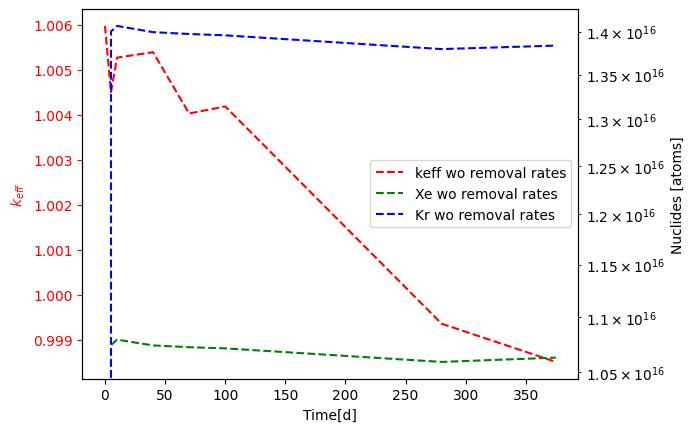

In [15]:
# Let's convert time from sec to days 
t /= (3600 * 24)

plt.figure()
ax = plt.subplot()
k1, = ax.plot(t, [k[0] for k in k], '--', c='red', label='keff wo removal rates')
ax1 = ax.twinx()
n1, = ax1.plot(t, n_xe, '--', c='green', label='Xe wo removal rates')
n3, = ax1.plot(t, n_kr, '--', c='blue', label='Kr wo removal rates')
ax.set_xlabel('Time[d]')
ax.set_ylabel(r'$k_{eff}$', color='r')
ax.tick_params(axis='y', colors='red')
ax1.set_yscale('log')
ax1.set_ylabel('Nuclides [atoms]')
ax1.legend(handles=[k1, n1, n3])
plt.show()

# Fission products
The removal rate for gaseous fission products has been tuned (see [here](https://info.ornl.gov/sites/publications/Files/Pub173113.pdf)) to obtain a Xenon poison fractions matching the measurements reported during the MSRE U235 operation, of 0.3%-0.4%. 

The Xenon poison fraction is defined as:
$FP = \frac{\Sigma_a^{135}Xe}{\Sigma_a^{235}U}$

Let's plot the same quantity and see if we obtain values that matches the reference :

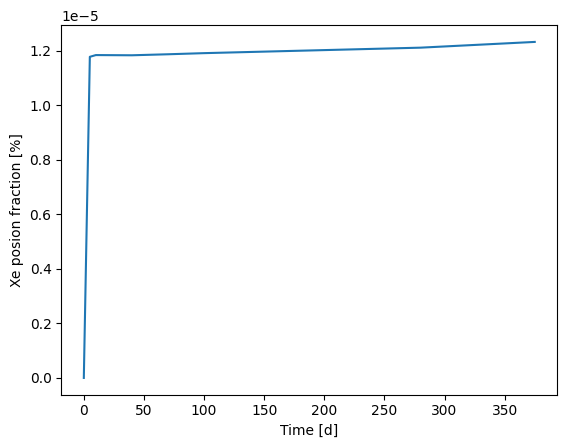

In [16]:
# Microscopic absorption cross section at 0.0253 eV
xs_xe135 = 2664214.0
xs_u235 = 686.006994850397
_, n_xe135 = results.get_atoms(str(salt.id), 'Xe135')
_, n_u235 = results.get_atoms(str(salt.id), 'U235')
# Poison fraction
pf = (xs_xe135*n_xe135)/(xs_u235*n_u235)*100
plt.figure()
plt.plot(t, pf)
plt.xlabel('Time [d]')
plt.ylabel('Xe posion fraction [%]')
plt.show()

# Inventory 


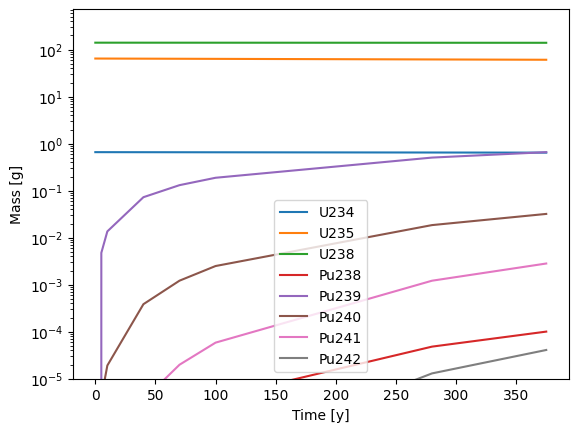

In [17]:
inventory = dict()
for nuc,_ in openmc.data.isotopes('U'):
    inventory[nuc] = results.get_atoms(str(salt.id), nuc)[1] / openmc.data.AVOGADRO * openmc.data.atomic_mass(nuc) / 1000

for nuc in ['Pu238','Pu239','Pu240','Pu241','Pu242']:
    inventory[nuc] = results.get_atoms(str(salt.id), nuc)[1] / openmc.data.AVOGADRO * openmc.data.atomic_mass(nuc) / 1000

plt.figure()
for nuc, mass in inventory.items():
    plt.plot(t, mass, label=nuc)
plt.xlabel('Time [y]')
plt.ylabel('Mass [g]')
plt.yscale('log')
plt.ylim(1e-5)
plt.legend()
plt.show()

# Neutron absorption in the fuel

In [18]:
import re
import seaborn as sns
regex = re.compile(r'(\d+|\s+)')

# All nuclides present in the fuel at last time-step
nucs = results.export_to_materials(-1)[0].get_nuclides()

# Let's begin by making some useful groupings
gaseos = ['H', 'He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn'] #gaseous fission products
noble_metals = ['Se','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Sb','Te'] # noble metals fission products
metals = ['Cr','Mn','Fe','Co','Ni','Cu','Zn','Hf','Zr','W',]
halogens = ['F','Cl','Br','I','At']
alkali_metals = ['Li','Na','K','Rb','Cs']
alkali_earths= ['Be','Mg','Ca','Sr','Ba','Ra']
lanthanides  = ['Y','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
m_a = ['Ac','Th','Pa','Np','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr']
# Get fissile nuclides in the fuel, based on Ronen's rule for determining fissile isotopes
fissile = []

for nuc in nucs:
    elm = regex.split(nuc)[0]
    a = round(openmc.data.atomic_mass(nuc))
    z = openmc.data.ATOMIC_NUMBER[elm]
    if 90 <= z <= 100:
        ronen = 2*z -(a-z)
        if ronen in [41,43,45]:
            fissile.append(nuc) 

# Calculate totat absorption rate of fissile nuclides
tot_abs_rate = 0
for nuc in fissile:
    tot_abs_rate += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
    tot_abs_rate += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]

nuclides_stack = dict()
groups_stack = {'Gaseos':0, 'Noble metals':0, 'Metals':0, 'Halogens':0 , 'Alkali metals':0, 'Alkali earths':0, 'Lanthanides':0, 'MA':0, 'Others':0}
for nuc in nucs:
    
    if regex.split(nuc)[0] in ['U','Pu']:
        nuclides_stack[nuc] = results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        nuclides_stack[nuc] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
        nuclides_stack[nuc] /= tot_abs_rate
        
        
    elif regex.split(nuc)[0] in gaseos:
        groups_stack['Gaseos'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Gaseos'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in noble_metals:
        groups_stack['Noble metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Noble metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in metals:
        groups_stack['Metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in halogens:
        groups_stack['Halogens'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Halogens'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in alkali_metals:
        groups_stack['Alkali metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Alkali metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in alkali_earths:
        groups_stack['Alkali earths'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Alkali earths'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in lanthanides:
        groups_stack['Lanthanides'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Lanthanides'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in m_a:
        groups_stack['MA'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['MA'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    else:
        groups_stack['Others'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Others'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]

# Divide each array by the total absorption reaction rate of fissile nuclides
for g in groups_stack.keys():
    groups_stack[g] /= tot_abs_rate

# Sort dictionary groups
groups_stack=dict(reversed(sorted(groups_stack.items(), key=lambda item: item[1][len(item)])))

# Create red color palette for groups_stack
colors = list(reversed(sns.color_palette("Reds", len(groups_stack))))

# Order uranium series
u_series = {key:value for key,value in nuclides_stack.items() if key.startswith('U')}
u_series = dict(reversed(sorted(u_series.items(), key=lambda item: item[1][len(item)])))
# Create green color palette for Uranium isotopes
colors += list(reversed(sns.color_palette("Greens", len(u_series))))

# Order plutionium series
pu_series = {key:value for key,value in nuclides_stack.items() if key.startswith('Pu')}
pu_series = dict(reversed(sorted(pu_series.items(), key=lambda item: item[1][len(item)])))
# Create blue color palette for plutonium isotopes
colors += list(reversed(sns.color_palette("Blues", len(pu_series))))
# Add uramium and plutonium series to the stack
groups_stack.update(u_series)
groups_stack.update(pu_series)

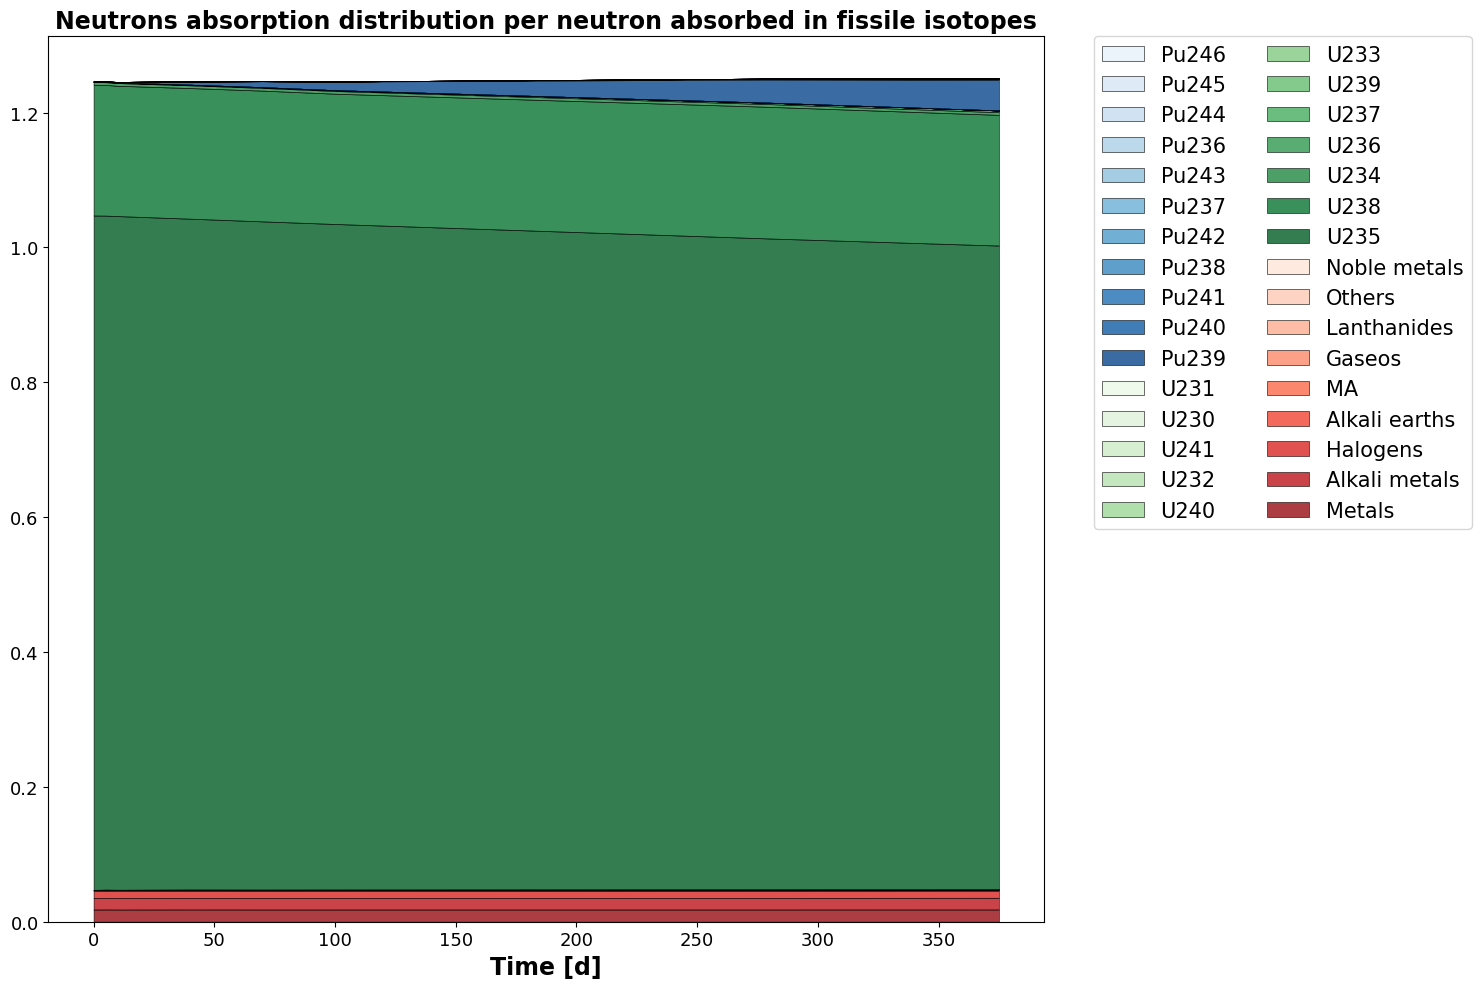

In [19]:
plt.figure(figsize=(15,10))
plt.stackplot(t, groups_stack.values(), labels=groups_stack.keys(), 
              edgecolor="black", linewidth=0.5,colors=colors, alpha=0.8)
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend([handles[idx] for idx in list(reversed(np.arange(0,len(handles),1)))],
                            [labels[idx] for idx in list(reversed(np.arange(0,len(handles),1)))],
                            bbox_to_anchor=(1.05,1), loc='upper left',
                            borderaxespad=0, ncol=2,
                            fontsize=15)
plt.xlabel('Time [d]',weight='bold',fontsize=17)
plt.title('Neutrons absorption distribution per neutron absorbed in fissile isotopes',
                   weight='bold', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

Here we can visualize the neutrons absorption for each nuclide present in the fuel per neutrons absorption by fissile isotopes. In other words we can see, out of the total neutrons generated, where and how many we end up losing.

It is useful to group together those isotopes with similar characteristics that individually wouldn't represent a big contribution to capture.

Due to the low burnup and relatively short simulation time, we are far from equilibrium. However, we can notice the quick increase of absorption in the Pu isotopes, created from neutron capture of U238, and in particular of Pu239, due to its higher absorption cross section than U235.

**Note**: Neutrons lost to leakage out of the core and capture in other isotopes other than fuel are not represented. Thus, approximately 1 neutron is missing from the counting (we know that a fission event releases approximately 2.3 neutrons). This is simply due to the fact that we have defined the fuel salt as our only depletable material.